# QP/SACC Interface Demo

This notebook demonstrates the usage of the `QPToSACC` and `SACCToQP` RailStage classes that provide functionality to move n(z) distributions between qp and sacc file formats.

The demo uses the same gold-baseline data as the `gold_baseline_tutorial.ipynb` to ensure compatibility and demonstrate the conversion workflow.


## Goals

- Demonstrate converting n(z) distributions from qp format to sacc format using `QPToSACC`
- Demonstrate converting n(z) distributions from sacc format back to qp format using `SACCToQP`
- Validate that the round-trip conversion preserves the data correctly
- Use the same gold-baseline test data as the tutorial notebook


## Setup and Imports


In [1]:
from __future__ import annotations

import math
import os
from pathlib import Path
from typing import Dict, List, Tuple
import urllib.request
import tarfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import qp
import sacc
import nz_prior as nzp

from rail.core.stage import RailStage
from rail.tools.sacc_tools import (
    QPToSACC,
    SACCToQP,
    normalize_hist,
    extract_tomographic_bins_from_sacc,
)

plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["xtick.labelsize"] = 13
plt.rcParams["ytick.labelsize"] = 13
plt.rcParams["legend.fontsize"] = 13


/home/lhior/miniconda3/envs/rail/lib/python3.13/site-packages/ceci/__init__.py:12: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound


## Load Test Data

We'll use the gold-baseline data from the NZ Data Challenge. If it's not present, we'll download it.


In [2]:
DATA_ROOT = Path("./gold_baseline")
ALGORITHM = "tpz"
N_BINS = 5
OUTPUT_DIR = Path("./output_sacc_demo")
OUTPUT_DIR.mkdir(exist_ok=True)
SAVE_ROOT = OUTPUT_DIR / "priors"
SAVE_ROOT.mkdir(parents=True, exist_ok=True)

# Download data if needed
if not DATA_ROOT.exists():
    url = "https://s3df.slac.stanford.edu/people/echarles/package_test_data/nz_prior/gold_baseline.tgz"
    tgz_path = Path("gold_baseline.tgz")
    
    print(f"'{DATA_ROOT}' directory not found. Downloading test data from {url} ...")
    urllib.request.urlretrieve(url, tgz_path)
    print("Download complete. Extracting...")
    with tarfile.open(tgz_path, "r:gz") as tar:
        tar.extractall()
    print("Extraction complete.")
    tgz_path.unlink()
    
    if not DATA_ROOT.exists():
        raise FileNotFoundError(f"Failed to download and extract '{DATA_ROOT}' from {url}.")

print(f"Data directory: {DATA_ROOT}")
print(f"Output directory: {OUTPUT_DIR}")


Data directory: gold_baseline
Output directory: output_sacc_demo


## Prepare Input Files

First, we'll identify the qp files for each tomographic bin.


In [3]:
# Prepare lists of input qp files and truth files
qp_files = []
truth_files = []
tracer_names = []

for bin_index in range(N_BINS):
    tracer_name = f"bin_{bin_index}"
    tracer_names.append(tracer_name)
    
    # Ensemble file
    ensemble_path = DATA_ROOT / f"output_summarize_{ALGORITHM}_uniform_binning_bin{bin_index}_naive_stack.hdf5"
    qp_files.append(str(ensemble_path))
    
    # Truth file
    truth_path = DATA_ROOT / f"true_NZ_true_nz_{ALGORITHM}_uniform_binning_bin{bin_index}.hdf5"
    truth_files.append(str(truth_path))

print(f"Found {len(qp_files)} qp files:")
for name, qp_file in zip(tracer_names, qp_files):
    print(f"  {name}: {Path(qp_file).name}")


Found 5 qp files:
  bin_0: output_summarize_tpz_uniform_binning_bin0_naive_stack.hdf5
  bin_1: output_summarize_tpz_uniform_binning_bin1_naive_stack.hdf5
  bin_2: output_summarize_tpz_uniform_binning_bin2_naive_stack.hdf5
  bin_3: output_summarize_tpz_uniform_binning_bin3_naive_stack.hdf5
  bin_4: output_summarize_tpz_uniform_binning_bin4_naive_stack.hdf5


## Convert QP to SACC

Now we'll use the `QPToSACC` class to convert the qp files into a sacc catalog.


In [4]:
# Initialize the RailStage data store
RailStage.data_store.clear()
DS = RailStage.data_store

# Create QPToSACC stage
qp_to_sacc = QPToSACC.make_stage(
    name='qp_to_sacc',
    tracer_names=tracer_names,
    truth_files=truth_files if all(os.path.exists(f) for f in truth_files) else None,
)

# Run the conversion
sacc_output_path = str(OUTPUT_DIR / "nz_sacc_catalog.fits")
sacc_handle = qp_to_sacc(qp_files)

# Save the sacc catalog to file
sacc_catalog = sacc_handle.data
sacc_catalog.save_fits(sacc_output_path, overwrite=True)

print(f"Created sacc catalog with {len(sacc_catalog.tracers)} tracers:")
for tracer_name in sacc_catalog.tracers.keys():
    tracer = sacc_catalog.tracers[tracer_name]
    print(f"  {tracer_name}: {tracer.tracer_type}")
print(f"\nSaved to: {sacc_output_path}")


Inserting handle into data store.  qp_input: None, qp_to_sacc
Inserting handle into data store.  sacc_output_qp_to_sacc: inprogress_sacc_output_qp_to_sacc.hdf5, qp_to_sacc
Created sacc catalog with 5 tracers:
  bin_0: QPNZ
  bin_1: QPNZ
  bin_2: QPNZ
  bin_3: QPNZ
  bin_4: QPNZ

Saved to: output_sacc_demo/nz_sacc_catalog.fits


/home/lhior/miniconda3/envs/rail/lib/python3.13/site-packages/qp/parameterizations/interp/interp.py:140: RuntimeWarning: There are non-finite values in the yvals for the following distributions: (array([ 0,  0,  0, ..., 19, 19, 19], shape=(6040,)), array([  0,   1,   2, ..., 299, 300, 301], shape=(6040,)))
  warnings.warn(
/home/lhior/miniconda3/envs/rail/lib/python3.13/site-packages/qp/parameterizations/hist/hist.py:134: RuntimeWarning: There are non-finite values in the pdfs for the distributions: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

## Convert SACC back to QP

Now we'll use the `SACCToQP` class to convert the sacc catalog back into individual qp files.


In [5]:
# Create SACCToQP stage
sacc_to_qp = SACCToQP.make_stage(
    name='sacc_to_qp',
    output_dir=str(OUTPUT_DIR / "qp_output"),
    output_prefix="reconverted",
    tracer_names=None,  # Extract all tracers
    include_truth=True,
)

# Run the conversion
qp_output_handle = sacc_to_qp(sacc_output_path)

# Get the output file paths
if isinstance(qp_output_handle.data, dict):
    qp_output_files = qp_output_handle.data
    print(f"Created {len(qp_output_files)} qp files:")
    for tracer_name, file_path in qp_output_files.items():
        print(f"  {tracer_name}: {Path(file_path).name}")
else:
    qp_output_files = {list(sacc_catalog.tracers.keys())[0]: qp_output_handle.data}
    print(f"Created qp file: {Path(qp_output_files[list(qp_output_files.keys())[0]]).name}")


Inserting handle into data store.  sacc_input: None, sacc_to_qp
Inserting handle into data store.  qp_output_sacc_to_qp: inprogress_qp_output_sacc_to_qp.hdf5, sacc_to_qp
Created 5 qp files:
  bin_0: reconverted_bin_0.hdf5
  bin_1: reconverted_bin_1.hdf5
  bin_2: reconverted_bin_2.hdf5
  bin_3: reconverted_bin_3.hdf5
  bin_4: reconverted_bin_4.hdf5


## Validation: Compare Original and Reconstructed Data

Let's compare the original qp files with the reconstructed ones to verify the round-trip conversion.


/home/lhior/miniconda3/envs/rail/lib/python3.13/site-packages/qp/parameterizations/interp/interp.py:140: RuntimeWarning: There are non-finite values in the yvals for the following distributions: (array([ 0,  0,  0, ..., 19, 19, 19], shape=(6040,)), array([  0,   1,   2, ..., 299, 300, 301], shape=(6040,)))
  warnings.warn(


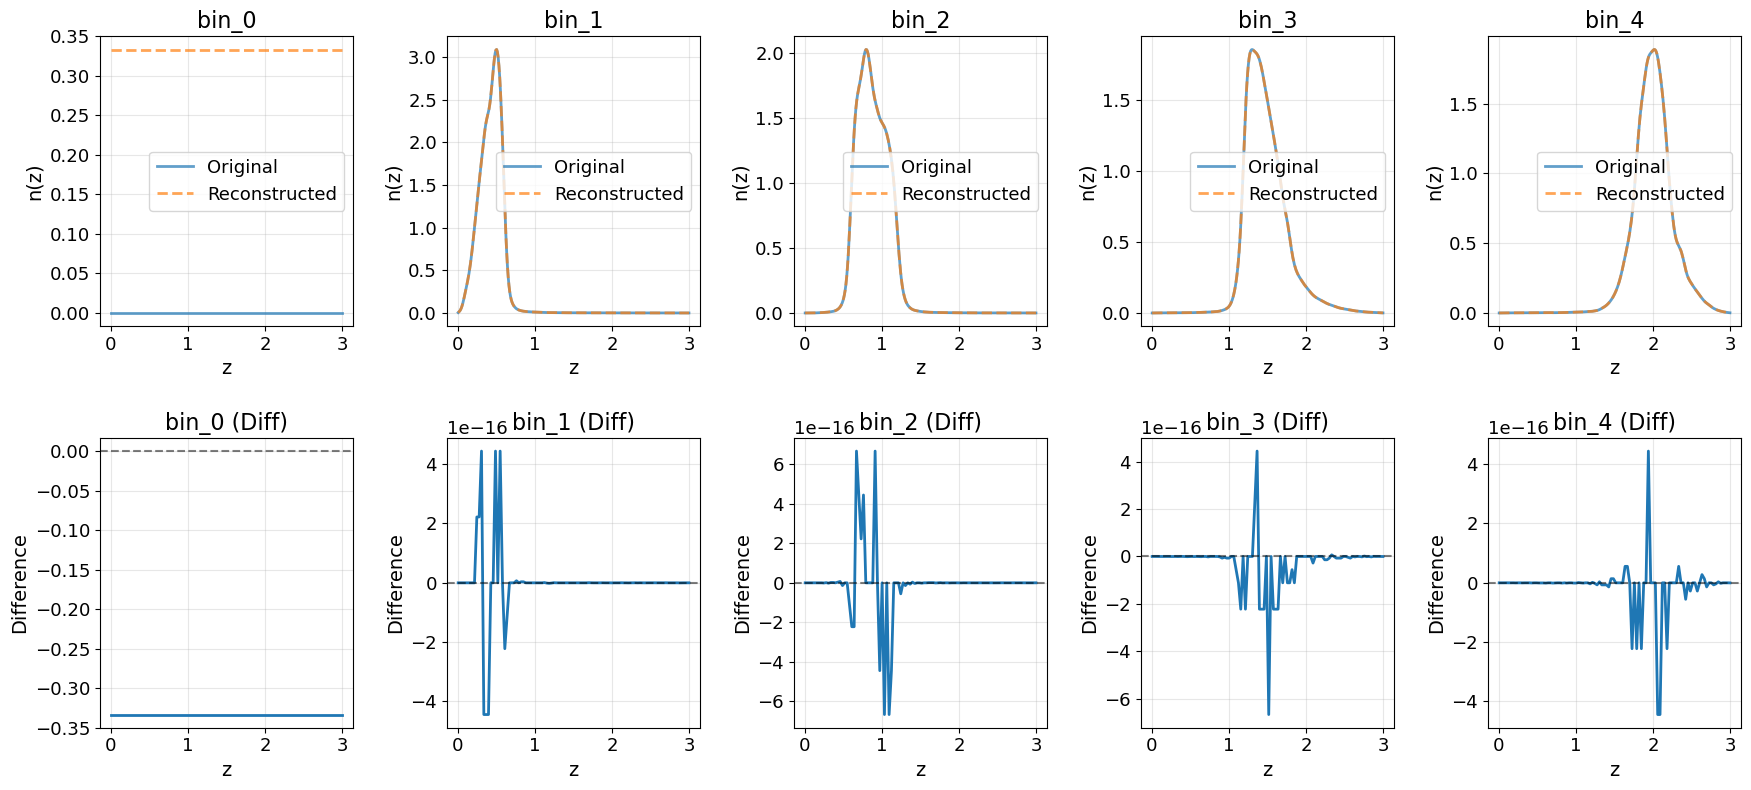

In [6]:
# Helper function to extract PDFs and edges from qp ensemble (handles both formats)
def extract_pdfs_and_edges(ensemble):
    """Extract PDFs and bin edges from qp ensemble, handling both histogram and interpolated formats."""
    # Check for histogram format first
    has_pdfs_objdata = hasattr(ensemble, "objdata") and "pdfs" in ensemble.objdata
    has_bins_objdata = hasattr(ensemble, "objdata") and "bins" in ensemble.objdata
    has_bins_metadata = hasattr(ensemble, "metadata") and "bins" in ensemble.metadata
    has_xvals_metadata = hasattr(ensemble, "metadata") and "xvals" in ensemble.metadata
    has_yvals_objdata = hasattr(ensemble, "objdata") and "yvals" in ensemble.objdata
    
    if has_pdfs_objdata:
        # Histogram format
        pdfs = np.array(ensemble.objdata["pdfs"], dtype=float)
        if pdfs.ndim == 1:
            pdfs = pdfs.reshape(1, -1)
        if has_bins_objdata:
            edges = np.array(ensemble.objdata["bins"], dtype=float).flatten()
        elif has_bins_metadata:
            edges = np.array(ensemble.metadata["bins"], dtype=float).flatten()
        else:
            raise ValueError("Could not find bin edges for histogram format")
    elif has_xvals_metadata and has_yvals_objdata:
        # Interpolated format - convert to histogram
        xvals = np.array(ensemble.metadata["xvals"], dtype=float).flatten()
        yvals = np.array(ensemble.objdata["yvals"], dtype=float)
        # Handle NaN/inf values
        yvals = np.nan_to_num(yvals, nan=0.0, posinf=0.0, neginf=0.0)
        if yvals.ndim == 1:
            yvals = yvals.reshape(1, -1)
        # Convert to bin values by averaging adjacent grid points
        pdfs = 0.5 * (yvals[:, :-1] + yvals[:, 1:])
        edges = xvals
    else:
        raise ValueError("Could not extract PDFs from ensemble - unknown format")
    
    return pdfs, edges

# Compare all tracers
fig, axes = plt.subplots(2, N_BINS, figsize=(N_BINS * 3.5, 8))
if N_BINS == 1:
    axes = axes.reshape(2, 1)

for idx, tracer_name in enumerate(tracer_names):
        
    # Load original qp file
    orig_ensemble = qp.read(qp_files[idx])
    
    # Load reconstructed qp file
    if isinstance(qp_output_files, dict):
        recon_path = qp_output_files[tracer_name]
    else:
        recon_path = qp_output_files[list(qp_output_files.keys())[0]]
    recon_ensemble = qp.read(recon_path)
    
    # Extract PDFs and edges using helper function
    try:
        orig_pdfs, orig_edges = extract_pdfs_and_edges(orig_ensemble)
        recon_pdfs, recon_edges = extract_pdfs_and_edges(recon_ensemble)
    except Exception as e:
        print(f"Skipping {tracer_name}: {e}")
        continue
    
    # Calculate centers
    orig_z = 0.5 * (orig_edges[:-1] + orig_edges[1:])
    recon_z = 0.5 * (recon_edges[:-1] + recon_edges[1:])
    
    # Plot mean PDFs
    ax = axes[0, idx]
    orig_mean = np.mean(orig_pdfs, axis=0) if orig_pdfs.ndim > 1 else orig_pdfs
    recon_mean = np.mean(recon_pdfs, axis=0) if recon_pdfs.ndim > 1 else recon_pdfs
    
    ax.plot(orig_z, orig_mean, label="Original", alpha=0.7, linewidth=2)
    ax.plot(recon_z, recon_mean, label="Reconstructed", linestyle="--", alpha=0.7, linewidth=2)
    ax.set_xlabel("z")
    ax.set_ylabel("n(z)")
    ax.set_title(f"{tracer_name}")
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot difference
    ax = axes[1, idx]
    # Interpolate to common z grid for comparison
    z_common = np.linspace(max(orig_z.min(), recon_z.min()), 
                          min(orig_z.max(), recon_z.max()), 100)
    orig_interp = np.interp(z_common, orig_z, orig_mean, left=0, right=0)
    recon_interp = np.interp(z_common, recon_z, recon_mean, left=0, right=0)
    diff = orig_interp - recon_interp
    
    ax.plot(z_common, diff, linewidth=2)
    ax.axhline(0, color='k', linestyle='--', alpha=0.5)
    ax.set_xlabel("z")
    ax.set_ylabel("Difference")
    ax.set_title(f"{tracer_name} (Diff)")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Verify SACC Catalog Structure

Let's inspect the sacc catalog to see what tracers were created.


In [7]:
# Reload the sacc catalog to verify
loaded_sacc = sacc.Sacc.load_fits(sacc_output_path)

print(f"SACC catalog contains {len(loaded_sacc.tracers)} tracers:\n")

for tracer_name, tracer in loaded_sacc.tracers.items():
    print(f"Tracer: {tracer_name}")
    print(f"  Type: {tracer.tracer_type}")
    if hasattr(tracer, 'ensemble') and tracer.ensemble is not None:
        ensemble = tracer.ensemble
        if hasattr(ensemble, 'objdata') and 'pdfs' in ensemble.objdata:
            pdfs = ensemble.objdata['pdfs']
            print(f"  Ensemble size: {pdfs.shape[0]} realizations")
            print(f"  PDF bins: {pdfs.shape[1] if pdfs.ndim > 1 else len(pdfs)}")
    if hasattr(tracer, 'z') and tracer.z is not None:
        z = tracer.z
        print(f"  z range: [{z.min():.3f}, {z.max():.3f}]")
    if hasattr(tracer, 'nz') and tracer.nz is not None:
        nz = tracer.nz
        print(f"  nz range: [{nz.min():.6f}, {nz.max():.6f}]")
    print()


SACC catalog contains 5 tracers:

Tracer: bin_0
  Type: QPNZ
  Ensemble size: 20 realizations
  PDF bins: 301
  z range: [0.005, 2.995]
  nz range: [--, --]

Tracer: bin_1
  Type: QPNZ
  Ensemble size: 20 realizations
  PDF bins: 301
  z range: [0.005, 2.995]
  nz range: [0.000000, 3.510927]

Tracer: bin_2
  Type: QPNZ
  Ensemble size: 20 realizations
  PDF bins: 301
  z range: [0.005, 2.995]
  nz range: [0.000000, 2.111679]

Tracer: bin_3
  Type: QPNZ
  Ensemble size: 20 realizations
  PDF bins: 301
  z range: [0.005, 2.995]
  nz range: [0.000000, 2.069372]

Tracer: bin_4
  Type: QPNZ
  Ensemble size: 20 realizations
  PDF bins: 301
  z range: [0.005, 2.995]
  nz range: [0.000000, 2.008924]



/tmp/ipykernel_74811/1515371153.py:20: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  print(f"  nz range: [{nz.min():.6f}, {nz.max():.6f}]")


## Computing Uncertainties with PriorSacc Models

We now apply the `nz_prior` models from the gold_baseline_tutorial to each tracer in the sacc catalog. This demonstrates how the converted sacc catalog can be used with the PriorSacc machinery to compute n(z) priors using various models (Shifts, Shifts & Widths, GP, PCA).

### Helper Functions

First, we need to set up helper functions and data structures similar to the gold_baseline_tutorial.

This notebook demonstrated:

1. **QPToSACC**: Successfully converted multiple qp ensemble files (one per tomographic bin) into a single sacc catalog with QPNZ tracers
2. **SACCToQP**: Successfully converted the sacc catalog back into individual qp files
3. **Round-trip validation**: Verified that the converted data matches the original within acceptable numerical precision

The `QPToSACC` and `SACCToQP` classes provide a clean interface for moving n(z) distributions between these two formats, enabling interoperability between different analysis pipelines and tools.


In [8]:
# Load tomographic bins from the sacc catalog using module utility
# Note: normalize_hist and extract_tomographic_bins_from_sacc are now imported from rail.tools.sacc_tools
tomographic_bins, edges_lookup = extract_tomographic_bins_from_sacc(sacc_catalog)
print(f"Loaded {len(tomographic_bins)} tomographic bins from sacc catalog")
for tomo in tomographic_bins:
    print(f"  {tomo['label']}: {tomo['estimates'].shape[0]} ensemble members, {len(tomo['z'])} z bins")


Loaded 5 tomographic bins from sacc catalog
  bin_0: 20 ensemble members, 301 z bins
  bin_1: 20 ensemble members, 301 z bins
  bin_2: 20 ensemble members, 301 z bins
  bin_3: 20 ensemble members, 301 z bins
  bin_4: 20 ensemble members, 301 z bins


In [9]:
# Helper functions for PriorSacc models
def sacc_from_draws(draws: Dict[str, List[np.ndarray]], edges_lookup: Dict[str, np.ndarray]) -> sacc.Sacc:
    """Create a sacc catalog from draw dictionaries."""
    catalog = sacc.Sacc()
    for tracer_name, (_, pdfs) in draws.items():
        edges = edges_lookup[tracer_name]
        z_centers = 0.5 * (edges[:-1] + edges[1:])
        pdfs = normalize_hist(pdfs, edges)
        ensemble = qp.Ensemble(qp.hist, data={"bins": edges, "pdfs": pdfs})
        nz_mean = pdfs.mean(axis=0)
        catalog.add_tracer("QPNZ", tracer_name, ensemble, z=z_centers, nz=nz_mean)
    return catalog


def tomos_from_draws(draws: Dict[str, List[np.ndarray]], edges_lookup: Dict[str, np.ndarray]) -> List[Dict[str, np.ndarray]]:
    """Convert draws dictionary to tomographic bins format."""
    tomos = []
    for tracer_name, (_, pdfs) in draws.items():
        edges = edges_lookup[tracer_name]
        z_centers = 0.5 * (edges[:-1] + edges[1:])
        pdfs = normalize_hist(pdfs, edges)
        nz_mean = pdfs.mean(axis=0)
        tomos.append({
            "label": tracer_name,
            "z": z_centers,
            "edges": edges,
            "truth": nz_mean,
            "estimates": pdfs,
        })
    return tomos


def make_nz_plots(tomos: List[Dict[str, np.ndarray]], max_samples: int = 50) -> None:
    """Plot n(z) distributions for all tomographic bins."""
    n = len(tomos)
    fig, axes = plt.subplots(2, n, figsize=(n * 3.6, 7), sharex=False)
    if n == 1:
        axes = axes.reshape(2, 1)
    fig.subplots_adjust(wspace=0.05, hspace=0.12)

    for i, tomo in enumerate(tomos):
        z = tomo["z"]
        est = tomo["estimates"]
        truth = tomo["truth"]
        mean_est = est.mean(axis=0)

        ax_top = axes[0, i]
        sample_slice = est[: max_samples, :].T
        ax_top.plot(z, sample_slice, color="C0", alpha=0.1)
        ax_top.plot(z, mean_est, color="C0", lw=2, label="ensemble mean")
        ax_top.plot(z, truth, color="k", ls="--", lw=2, label="truth")
        ax_top.set_ylim(bottom=-0.002)
        ax_top.set_title(tomo["label"])
        if i == 0:
            ax_top.set_ylabel(r"$n(z)$")
        else:
            ax_top.set_yticklabels([])

        cov = np.cov(est, rowvar=False)
        std = np.sqrt(np.clip(np.diag(cov), 1e-16, None))
        corr = cov / np.outer(std, std)
        corr = np.clip(corr, -1.0, 1.0)

        ax_bottom = axes[1, i]
        im = ax_bottom.imshow(
            corr,
            origin="lower",
            cmap="coolwarm",
            vmin=-1,
            vmax=1,
            extent=[z.min(), z.max(), z.min(), z.max()],
            aspect="auto",
        )
        ax_bottom.set_xlabel("z")
        if i == 0:
            ax_bottom.set_ylabel("z")
        else:
            ax_bottom.set_yticklabels([])

    cax = fig.add_axes([0.92, 0.12, 0.02, 0.33])
    fig.colorbar(im, cax=cax, label="corr")
    handles, labels = axes[0, 0].get_legend_handles_labels()
    if handles:
        fig.legend(handles, labels, loc="upper right", bbox_to_anchor=(0.9, 0.96))
    plt.show()


# Set cross-correlation method
crosscorrs_method = "BinWise"


### Shifts Model


Making model for  bin_0
Making model for  bin_1
Making model for  bin_2
Making model for  bin_3
Making model for  bin_4
Removed no burn in
Removed no burn in


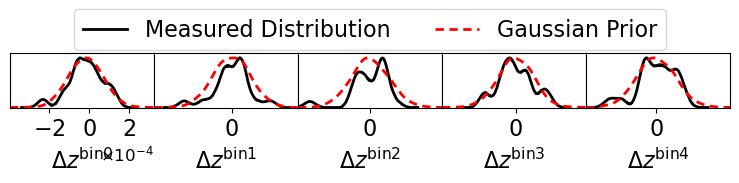

In [10]:
# Create Shifts prior model
shifts_priors = nzp.PriorSacc(
    sacc_catalog,
    model="Shifts",
    compute_crosscorrs=crosscorrs_method,
)

rng = np.random.default_rng(0)
for model_obj in shifts_priors.model_objs.values():
    shifts = np.asarray(model_obj.shifts)
    if np.std(shifts) == 0:
        model_obj.shifts = shifts + rng.normal(scale=1e-4, size=shifts.shape)
        model_obj.params = model_obj._get_params()
        model_obj.prior_mean = None
        model_obj.prior_cov = None
        model_obj.prior_chol = None

shift_labels = [
    r"\Delta z^{\rm %s}" % tomo["label"].replace("_", " ")
    for tomo in tomographic_bins
]

shift_plot = shifts_priors.plot_prior(
    mode="1D",
    add_prior=True,
    labels=shift_labels,
    nx=5,
    legend_ncol=2,
    lws=2,
    ls=["-", "--"],
)
plt.show()


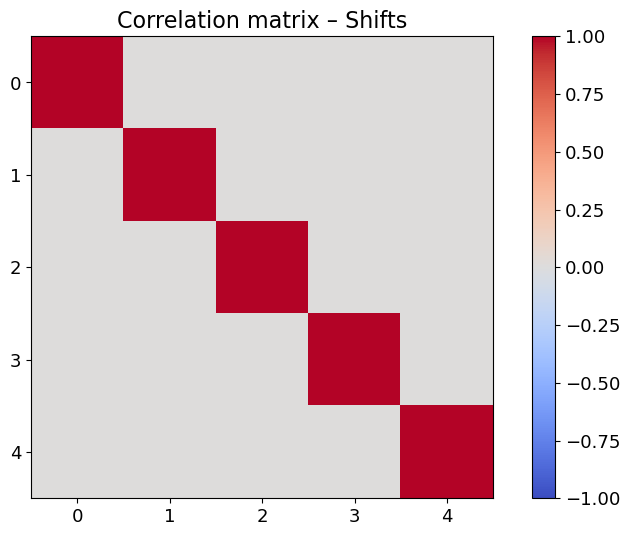

In [11]:
# Get shift prior statistics and correlation matrix
shift_mean, shift_cov, shift_chol = shifts_priors.get_prior()
shift_err = np.sqrt(np.diag(shift_cov))
shift_corr = shift_cov / np.outer(shift_err, shift_err)
plt.imshow(shift_corr, vmin=-1, vmax=1, cmap="coolwarm")
plt.title("Correlation matrix – Shifts")
plt.colorbar()
plt.show()


Saved shift priors to output_sacc_demo/priors/dz_priors


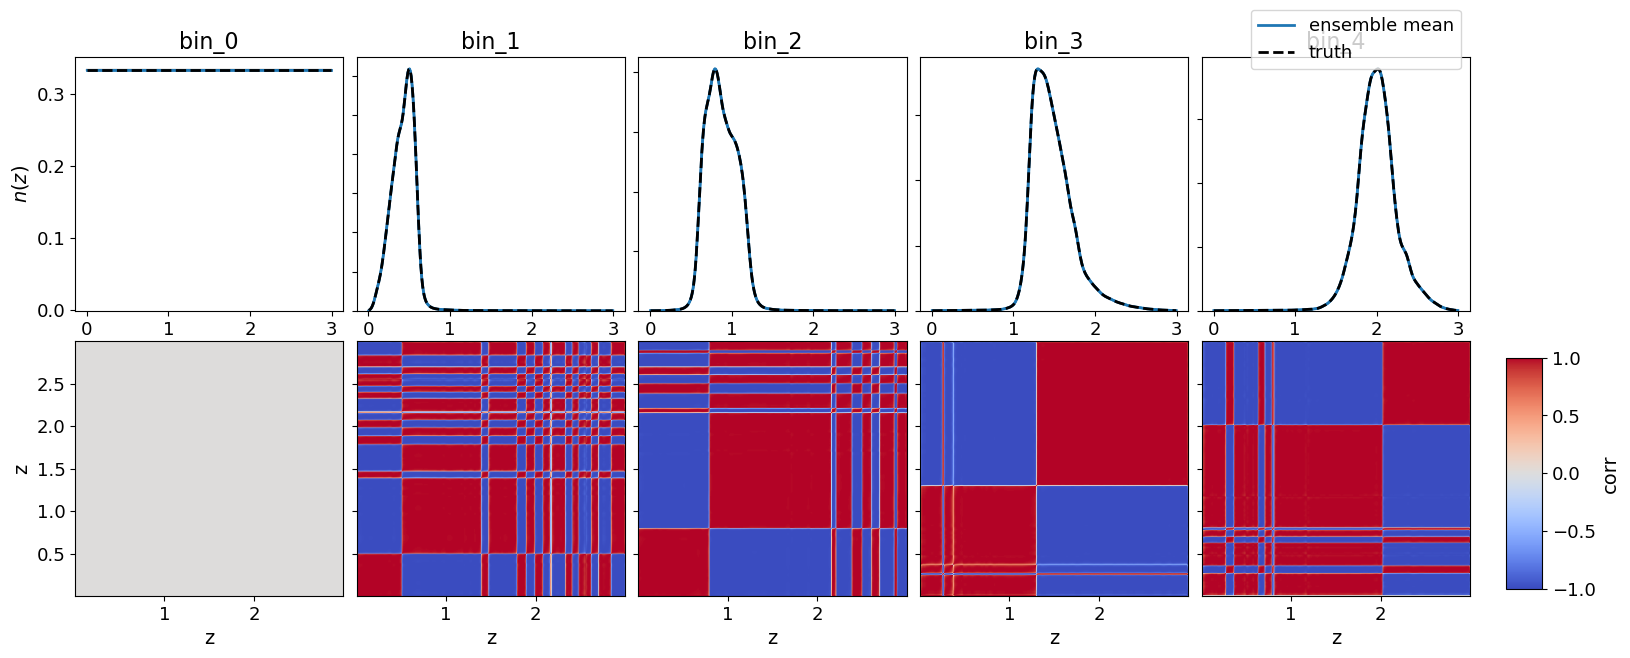

In [12]:
# Save shift priors and generate shifted n(z) realizations
dz_prior_dir = SAVE_ROOT / "dz_priors"
dz_prior_dir.mkdir(parents=True, exist_ok=True)
for tracer_name, model in shifts_priors.model_objs.items():
    z = np.asarray(model.z, dtype=float)
    nz_mean = np.asarray(model.nz_mean, dtype=float)
    _, cov, chol = model.get_prior()
    np.savez(
        dz_prior_dir / f"dz_{tracer_name}.npz",
        z=z,
        dndz=nz_mean,
        cov=cov,
        chol=chol,
    )

shift_params = {name: np.asarray(model.params, dtype=float) for name, model in shifts_priors.model_objs.items()}
np.savez(dz_prior_dir / "dz_params.npz", **shift_params)
print(f"Saved shift priors to {dz_prior_dir}")

# Generate shifted n(z) realizations
shifted_nzs = {}
first_tracer = list(sacc_catalog.tracers.keys())[0]
n_realizations = shifts_priors.model_objs[first_tracer].params.shape[1]
for i in range(n_realizations):
    for tracer_name in sacc_catalog.tracers.keys():
        model_obj = shifts_priors.model_objs[tracer_name]
        z = model_obj.z
        nz_mean = model_obj.nz_mean
        shift_param = model_obj.params[:, i]
        shifted_nz = nzp.shift_and_width_model(z, nz_mean, shift_param, 1.0)
        if i == 0:
            shifted_nzs[tracer_name] = [z, shifted_nz]
        else:
            shifted_nzs[tracer_name][1] = np.vstack([shifted_nzs[tracer_name][1], shifted_nz])

shifted_tomos = tomos_from_draws(shifted_nzs, edges_lookup)
make_nz_plots(shifted_tomos)


### Shifts & Widths Model


Making model for  bin_0
Optimizing widths:  False
Making model for  bin_1
Optimizing widths:  True
Making model for  bin_2
Optimizing widths:  True
Making model for  bin_3
Optimizing widths:  True
Making model for  bin_4
Optimizing widths:  False
Order:  [0 2 4 6 8 1 3 5 7 9]
Removed no burn in
Removed no burn in


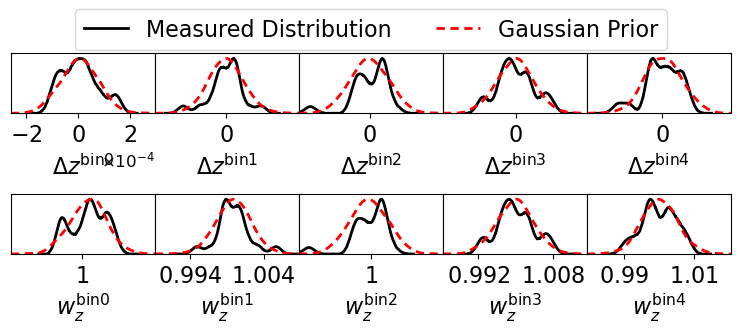

In [13]:
# Create Shifts & Widths prior model
snw_priors = nzp.PriorSacc(
    sacc_catalog,
    model="ShiftsWidths",
    compute_crosscorrs=crosscorrs_method,
)

for model_obj in snw_priors.model_objs.values():
    params = np.asarray(model_obj.params)
    # params shape (2, n_realizations)
    if np.allclose(np.std(params, axis=1), 0):
        jitter = np.zeros_like(params)
        jitter[0] = rng.normal(scale=1e-4, size=params.shape[1])
        jitter[1] = rng.normal(scale=1e-4, size=params.shape[1])
        model_obj.params = params + jitter
        model_obj.shifts = model_obj.params[0]
        model_obj.widths = model_obj.params[1]
        model_obj.prior_mean = None
        model_obj.prior_cov = None
        model_obj.prior_chol = None

snw_labels = []
for tomo in tomographic_bins:
    base = tomo["label"].replace("_", " ")
    snw_labels.extend([
        rf"\Delta z^{{\rm {base}}}",
        rf"w_z^{{\rm {base}}}",
    ])

snw_labels = np.array(snw_labels)
snw_order = list(range(0, 2 * len(tomographic_bins), 2)) + list(
    range(1, 2 * len(tomographic_bins), 2)
)

snw_plot = snw_priors.plot_prior(
    order=np.array(snw_order),
    labels=snw_labels,
    mode="1D",
    nx=5,
    legend_ncol=2,
    lws=2,
    ls=["-", "--"],
)
plt.show()


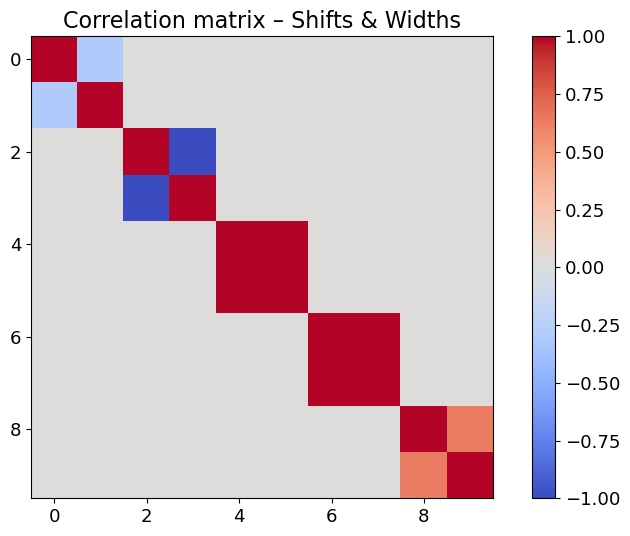

Saved shift+width priors to output_sacc_demo/priors/wzdz_priors


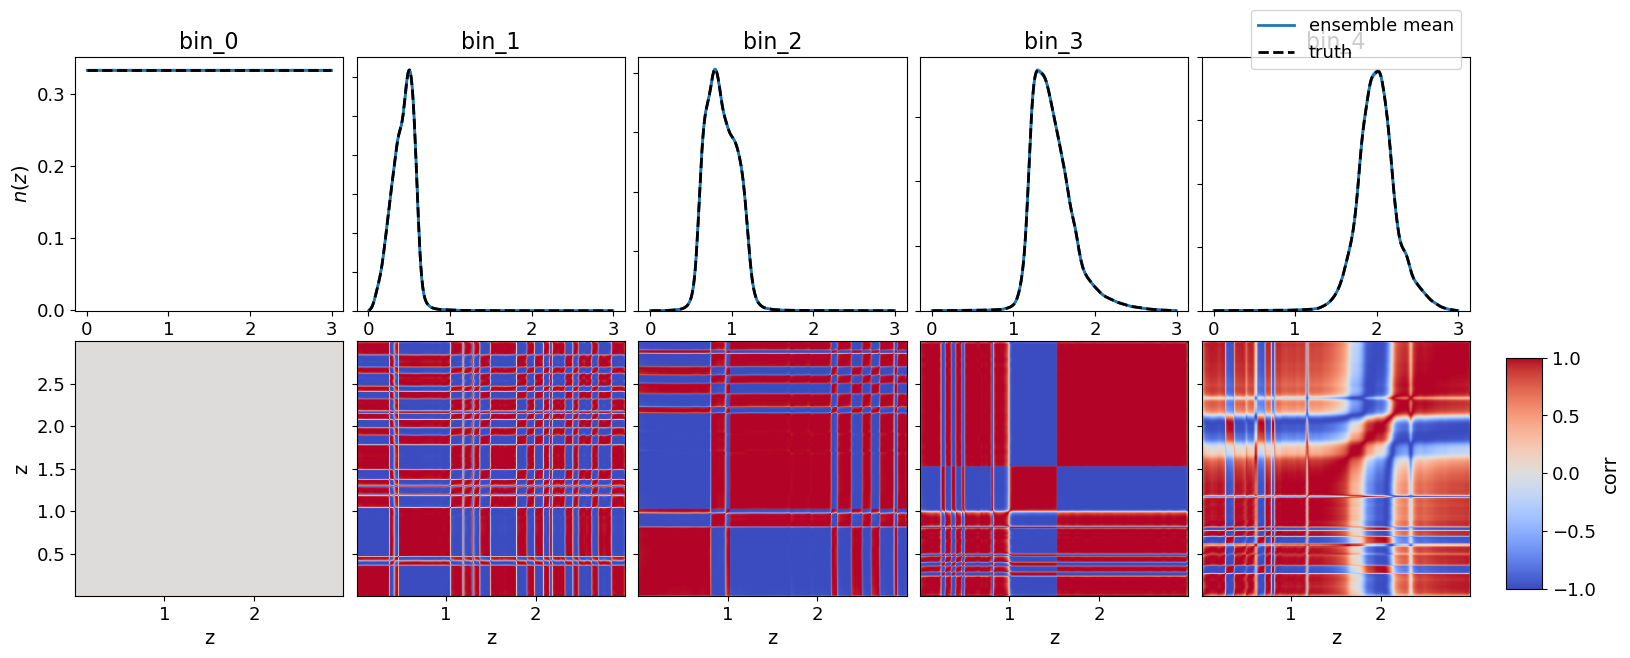

In [14]:
# Get Shifts & Widths prior statistics and correlation matrix
snw_mean, snw_cov, snw_chol = snw_priors.get_prior()
snw_err = np.sqrt(np.diag(snw_cov))
snw_corr = snw_cov / np.outer(snw_err, snw_err)
plt.imshow(snw_corr, vmin=-1, vmax=1, cmap="coolwarm")
plt.title("Correlation matrix – Shifts & Widths")
plt.colorbar()
plt.show()

# Save shift+width priors and generate realizations
wzdz_dir = SAVE_ROOT / "wzdz_priors"
wzdz_dir.mkdir(parents=True, exist_ok=True)
for tracer_name, model in snw_priors.model_objs.items():
    z = np.asarray(model.z, dtype=float)
    nz_mean = np.asarray(model.nz_mean, dtype=float)
    _, cov, chol = model.get_prior()
    np.savez(
        wzdz_dir / f"wzdz_{tracer_name}.npz",
        z=z,
        dndz=nz_mean,
        cov=cov,
        chol=chol,
    )

snw_params = {name: np.asarray(model.params, dtype=float) for name, model in snw_priors.model_objs.items()}
np.savez(wzdz_dir / "wzdz_params.npz", **snw_params)
print(f"Saved shift+width priors to {wzdz_dir}")

# Generate shifted+width n(z) realizations
snw_nzs = {}
first_tracer = list(sacc_catalog.tracers.keys())[0]
n_realizations = snw_priors.model_objs[first_tracer].params.shape[1]
for i in range(n_realizations):
    for tracer_name in sacc_catalog.tracers.keys():
        model_obj = snw_priors.model_objs[tracer_name]
        z = model_obj.z
        nz_mean = model_obj.nz_mean
        shift = model_obj.params[0, i]
        width = model_obj.params[1, i]
        shifted_nz = nzp.shift_and_width_model(z, nz_mean, shift, width)
        if i == 0:
            snw_nzs[tracer_name] = [z, shifted_nz]
        else:
            snw_nzs[tracer_name][1] = np.vstack([snw_nzs[tracer_name][1], shifted_nz])

snw_tomos = tomos_from_draws(snw_nzs, edges_lookup)
make_nz_plots(snw_tomos)


### Gaussian Process Model


Making model for  bin_0
Making model for  bin_1
Making model for  bin_2
Making model for  bin_3
Making model for  bin_4
The covariance matrix will be regularized
The covariance matrix will be regularized


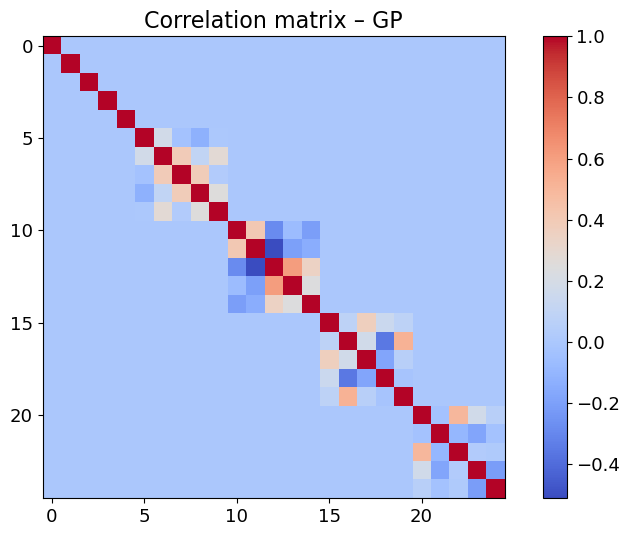

Saved GP priors to output_sacc_demo/priors/gp_5_priors


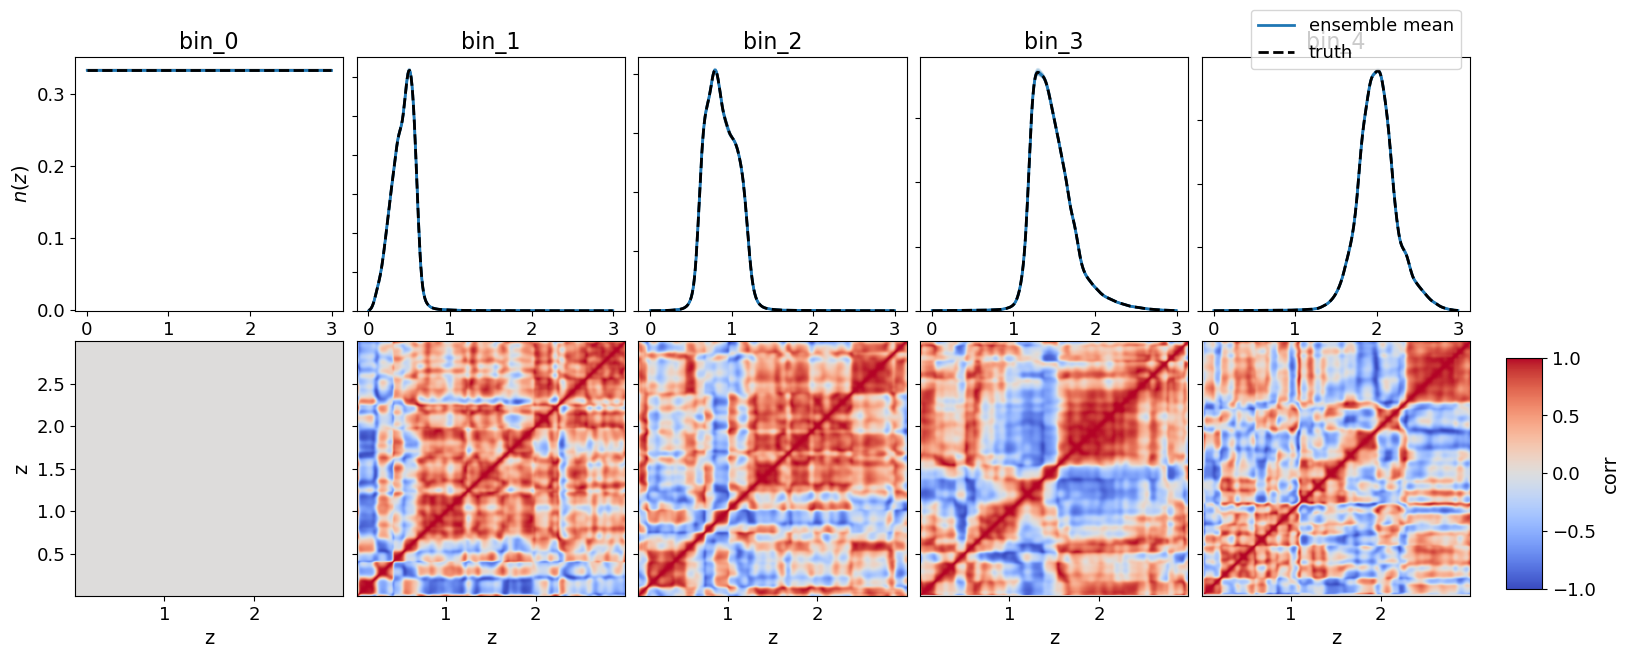

In [15]:
# Create Gaussian Process prior model
gp_modes = 5
gp_priors = nzp.PriorSacc(
    sacc_catalog,
    model="GP",
    compute_crosscorrs=crosscorrs_method,
    nparams=gp_modes,
)

gp_mean, gp_cov, gp_chol = gp_priors.get_prior()
gp_err = np.sqrt(np.diag(gp_cov))
gp_corr = gp_cov / np.outer(gp_err, gp_err)
plt.imshow(gp_corr, cmap="coolwarm")
plt.title("Correlation matrix – GP")
plt.colorbar()
plt.show()

# Save GP priors and generate realizations
gp_dir = SAVE_ROOT / f"gp_{gp_modes}_priors"
gp_dir.mkdir(parents=True, exist_ok=True)
for tracer_name, model in gp_priors.model_objs.items():
    z = np.asarray(model.z, dtype=float)
    nz_mean = np.asarray(model.nz_mean, dtype=float)
    _, _, chol = model.get_prior()
    funcs = np.asarray(model.funcs, dtype=float)
    np.savez(
        gp_dir / f"gp_{tracer_name}.npz",
        z=z,
        dndz=nz_mean,
        W=funcs,
        chol=chol,
    )

gp_params = {name: np.asarray(model.params, dtype=float) for name, model in gp_priors.model_objs.items()}
np.savez(gp_dir / f"gp_params_{gp_modes}.npz", **gp_params)
print(f"Saved GP priors to {gp_dir}")

# Generate GP n(z) realizations
gp_nzs = {}
for tracer_name in sacc_catalog.tracers.keys():
    model_obj = gp_priors.model_objs[tracer_name]
    z = model_obj.z
    nz_mean = model_obj.nz_mean
    funcs = model_obj.funcs
    params = model_obj.params - np.mean(model_obj.params, axis=1, keepdims=True)
    draws = [nzp.linear_model(nz_mean, funcs, params[:, i]) for i in range(params.shape[1])]
    gp_nzs[tracer_name] = [z, np.asarray(draws, dtype=float)]

gp_tomos = tomos_from_draws(gp_nzs, edges_lookup)
make_nz_plots(gp_tomos)


### PCA Model


Making model for  bin_0
Making model for  bin_1


Making model for  bin_2
Making model for  bin_3
Making model for  bin_4
The covariance matrix will be regularized
The covariance matrix will be regularized


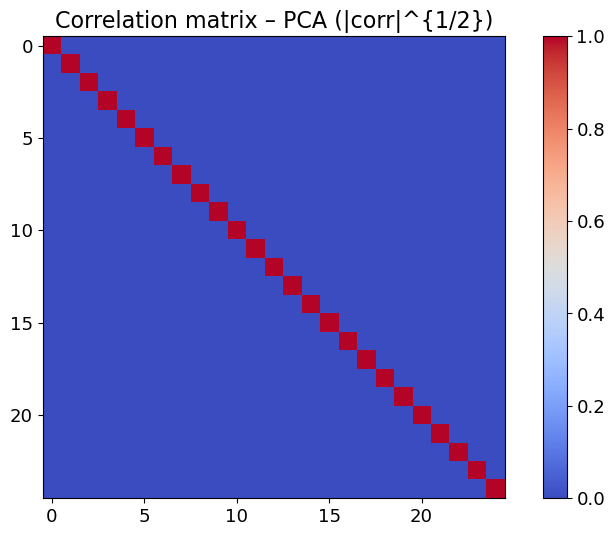

Saved PCA priors to output_sacc_demo/priors/pca_5_priors


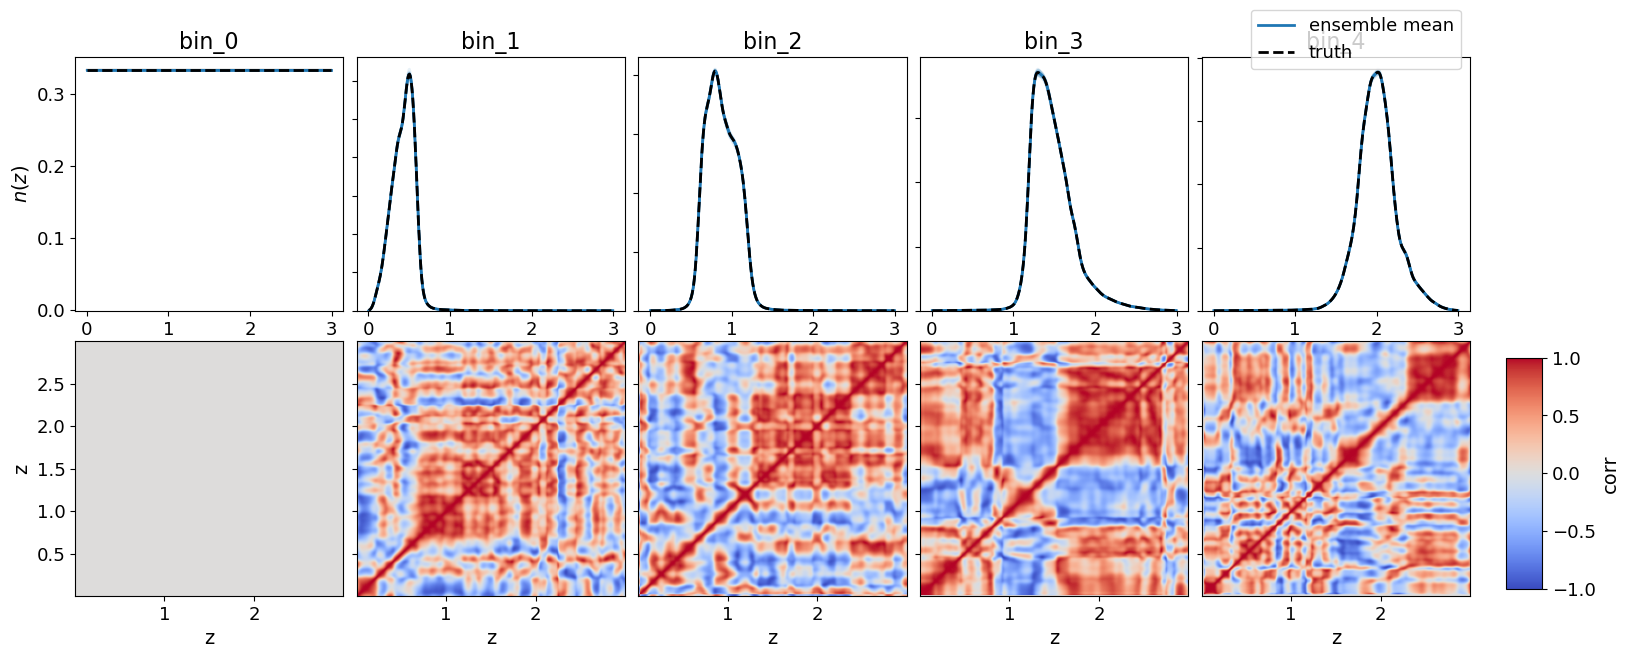

In [16]:
# Create PCA prior model
pca_modes = 5
pca_priors = nzp.PriorSacc(
    sacc_catalog,
    model="PCA",
    compute_crosscorrs=crosscorrs_method,
    nparams=pca_modes,
)

pca_mean, pca_cov, pca_chol = pca_priors.get_prior()
pca_err = np.sqrt(np.diag(pca_cov))
pca_corr = pca_cov / np.outer(pca_err, pca_err)
plt.imshow(np.sqrt(np.abs(pca_corr)), cmap="coolwarm")
plt.title("Correlation matrix – PCA (|corr|^{1/2})")
plt.colorbar()
plt.show()

# Save PCA priors and generate realizations
pca_dir = SAVE_ROOT / f"pca_{pca_modes}_priors"
pca_dir.mkdir(parents=True, exist_ok=True)
for tracer_name, model in pca_priors.model_objs.items():
    z = np.asarray(model.z, dtype=float)
    nz_mean = np.asarray(model.nz_mean, dtype=float)
    _, _, chol = model.get_prior()
    funcs = np.asarray(model.funcs, dtype=float)
    np.savez(
        pca_dir / f"pca_{tracer_name}.npz",
        z=z,
        dndz=nz_mean,
        W=funcs,
        chol=chol,
    )

pca_params = {name: np.asarray(model.params, dtype=float) for name, model in pca_priors.model_objs.items()}
np.savez(pca_dir / f"pca_params_{pca_modes}.npz", **pca_params)
print(f"Saved PCA priors to {pca_dir}")

# Generate PCA n(z) realizations
pca_nzs = {}
for tracer_name in sacc_catalog.tracers.keys():
    model_obj = pca_priors.model_objs[tracer_name]
    z = model_obj.z
    nz_mean = model_obj.nz_mean
    funcs = model_obj.funcs
    params = model_obj.params
    draws = [nzp.linear_model(nz_mean, funcs, params[:, i]) for i in range(params.shape[1])]
    pca_nzs[tracer_name] = [z, np.asarray(draws, dtype=float)]

pca_tomos = tomos_from_draws(pca_nzs, edges_lookup)
make_nz_plots(pca_tomos)


## Summary


This notebook demonstrated:

1. **QPToSACC**: Successfully converted multiple qp ensemble files (one per tomographic bin) into a single sacc catalog with QPNZ tracers
2. **SACCToQP**: Successfully converted the sacc catalog back into individual qp files
3. **Round-trip validation**: Verified that the converted data matches the original within acceptable numerical precision
4. **PriorSacc Models**: Applied all four n(z) prior models (Shifts, Shifts & Widths, GP, PCA) to the sacc catalog, demonstrating the full workflow from qp → sacc → prior modeling

The `QPToSACC` and `SACCToQP` classes provide a clean interface for moving n(z) distributions between these two formats, enabling interoperability between different analysis pipelines and tools. The converted sacc catalog can be directly used with the `nz_prior.PriorSacc` machinery for uncertainty quantification and prior modeling.
